In [1]:
# imports
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima import auto_arima

pd.options.plotting.backend = 'plotly'

# read data
df_store = pd.read_pickle('data/df_daily.pkl')
ts_company = df_store.groupby('date').sum()['sales']/1e6


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/sktime/utils/validation/series.py:22: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [2]:
ts_company.index.freq = 'D'

In [8]:
pd.DataFrame([ts_company, ts_company.shift(1)]).T


,sales,sales
date,,
2017-08-07,1.527650,NaN
2017-08-08,0.000000,1.527650
2017-08-09,34.942320,0.000000
2017-08-10,20.151840,34.942320
2017-08-11,24.305380,20.151840
...,...,...
2021-01-27,669.639716,710.355464
2021-01-28,720.317779,669.639716
2021-01-29,882.390069,720.317779


In [9]:
pd.DataFrame({'T': ts_company,
              'lag_1': ts_company.shift(1),
              'lag_2': ts_company.shift(2),
              'lag_3': ts_company.shift(3),
              'lag_4': ts_company.shift(4),
              })

,T,lag_1,lag_2,lag_3,lag_4
date,,,,,
2017-08-07,1.527650,NaN,NaN,NaN,NaN
2017-08-08,0.000000,1.527650,NaN,NaN,NaN
2017-08-09,34.942320,0.000000,1.527650,NaN,NaN
2017-08-10,20.151840,34.942320,0.000000,1.527650,NaN
2017-08-11,24.305380,20.151840,34.942320,0.000000,1.527650
...,...,...,...,...,...
2021-01-27,669.639716,710.355464,641.339600,1672.900088,1207.594290
2021-01-28,720.317779,669.639716,710.355464,641.339600,1672.900088
2021-01-29,882.390069,720.317779,669.639716,710.355464,641.339600


---
# Visual inspection
## Time plot
The dataset spans between August 2017 and January 2021, inclusively. Although more recent data is available, we decide to exclude them because since February 2021, Vietnam went through consecutive COVID lockdown periods during which, non-essential activities (including fashion retailing) had been largely inactive.

Insights from time plot:
* TREND: There is no obvious upward or downward trend in the dataset.
* SEASONALITY:
    * WEEKLY seasonality is very clear. Most peaks occur on Sundays. 
    * ANNUAL seasonality also exists:
        * The highest peaks take place at the end of November due to the major promotions of Black Friday every year.
        * The troughs occur on January/February due to Lunar New Year holidays. Total sales remains low in the 2 next months.

In [27]:
df_exog = pd.DataFrame(index=ts_company.index)
off_day_idx = [
    pd.date_range('2018-02-15', '2018-02-20'),  # Lunar New Year
    pd.date_range('2019-02-04', '2019-02-09'),  # Lunar New Year
    pd.date_range('2020-01-24', '2020-01-29'),  # Lunar New Year
    pd.date_range('2018-05-01', '2018-05-01'),  # Labor Day
    pd.date_range('2019-05-01', '2019-05-01'),  # Labor Day
    pd.date_range('2020-05-01', '2020-05-01'),  # Labor Day
]
off_day_idx = pd.DatetimeIndex(np.unique(np.hstack(off_day_idx)))
df_exog['off_day'] = False
df_exog.loc[off_day_idx, 'off_day'] = True

promo_day_idx = [
    # Black Friday
    pd.date_range(end='2017-11-24', periods=7),
    pd.date_range(end='2018-11-23', periods=7),
    pd.date_range(end='2019-11-29', periods=7),
    pd.date_range(end='2020-11-27', periods=7),
    # End of year
    pd.date_range(end='2018-02-15', periods=15, inclusive='neither'),
    pd.date_range(end='2019-02-04', periods=15, inclusive='neither'),
    pd.date_range(end='2020-01-24', periods=15, inclusive='neither'),
    pd.date_range(end='2021-01-31', periods=3, inclusive='both'), # 2021 Tet is on 2021-02-12
    # Valentine
    pd.date_range(end='2018-02-14', periods=7),
    pd.date_range(end='2019-02-14', periods=7),
    pd.date_range(end='2020-02-14', periods=7),
    # International Women’s day
    pd.date_range(end='2018-03-08', periods=7),
    pd.date_range(end='2019-03-08', periods=7),
    pd.date_range(end='2020-03-08', periods=7),
    # Vietnam Reunification day
    pd.date_range(end='2018-04-30', periods=10),
    pd.date_range(end='2019-04-30', periods=10),
    pd.date_range(end='2020-04-30', periods=10),
    # End of school year
    pd.date_range(end='2018-05-27', periods=4),
    pd.date_range(end='2019-05-27', periods=4),
    pd.date_range(end='2020-05-27', periods=4),
    # New school year
    pd.date_range(end='2018-08-26', periods=3),
    pd.date_range(end='2019-08-26', periods=3),
    pd.date_range(end='2020-08-26', periods=3),
    # Vietnamese Women’s day
    pd.date_range(end='2018-10-20', periods=1),
    pd.date_range(end='2019-10-20', periods=1),
    pd.date_range(end='2020-10-20', periods=1),
]
promo_day_idx = pd.DatetimeIndex(np.unique(np.hstack(promo_day_idx)))
df_exog['promo_day'] = False
df_exog.loc[promo_day_idx, 'promo_day'] = True
df_exog = df_exog.astype('int')
# df_exog.to_pickle('data/df_exog.pkl')


In [24]:
df_exog.sum()

off_day       21
promo_day    162
dtype: int64

In [84]:
# time series plot
fig = ts_company.plot()

# # off_day
# off_day_color = "red"
# for day in df_exog.loc[df_exog.off_day==True, 'off_day'].index:
#     fig.add_vline(x=day, line=dict(color=off_day_color))

# # promo_day
# promo_day_color = "green"
# for day in df_exog.loc[df_exog.promo_day==True, 'promo_day'].index:
#     fig.add_vline(x=day, line=dict(color=promo_day_color))


fig.update_layout(title_text='Company sales',
                  legend_title_text='Legend:',
                  width=1000)
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Sum of sales')

fig.update_layout(hovermode="x unified")

fig.show()

In [ ]:
# time series plot
fig = ts_company.plot()

# off_day
off_day_color = "red"
# fig.add_vrect(x0='2018-02-15', x1='2018-02-21', line_width=0, fillcolor=off_day_color, opacity=0.3) # Lunar New Year
# fig.add_vrect(x0='2019-02-04', x1='2019-02-10', line_width=0, fillcolor=off_day_color, opacity=0.3) # Lunar New Year
# fig.add_vrect(x0='2020-01-24', x1='2020-01-30', line_width=0, fillcolor=off_day_color, opacity=0.3) # Lunar New Year
# fig.add_vrect(x0='2018-05-01', x1='2018-05-02', line_width=0, fillcolor=off_day_color, opacity=0.3) # Labor Day
# fig.add_vrect(x0='2019-05-01', x1='2019-05-02', line_width=0, fillcolor=off_day_color, opacity=0.3) # Labor Day
fig.add_vrect(x0='2020-05-01', x1='2020-05-01', line_width=1, fillcolor=off_day_color, opacity=0.3) # Labor Day
fig.add_vrect(x0='2020-05-02', x1='2020-05-02', line_width=1, fillcolor=off_day_color, opacity=0.3) # Labor Day

# promo_day
promo_day_color = "green"
# Black Friday (fourth Friday in November; fifth Friday if November 1st is a Friday)
fig.add_vrect(x0='2017-11-17', x1='2017-11-24', line_width=0, fillcolor=promo_day_color, opacity=0.3)
fig.add_vrect(x0='2018-11-16', x1='2018-11-23', line_width=0, fillcolor=promo_day_color, opacity=0.3)
fig.add_vrect(x0='2019-11-22', x1='2019-11-29', line_width=0, fillcolor=promo_day_color, opacity=0.3)
fig.add_vrect(x0='2020-11-20', x1='2020-11-27', line_width=0, fillcolor=promo_day_color, opacity=0.3)

# End of year (both Gregorian & Lunar calendars)

# Valentine (February 14; except when coincide with Lunar New Year)
# fig.add_vrect(x0='2018-02-16', x1='2018-11-23', line_width=0, fillcolor=promo_day_color, opacity=0.3)

# International Women’s day (March 8)
# fig.add_vrect(x0='2018-11-16', x1='2018-11-23', line_width=0, fillcolor=promo_day_color, opacity=0.3)

# Vietnam Reunification day (April 30)
# End of school year (end of May)
# New school year (end of August)
# Vietnamese Women’s day (October 20)

fig.update_layout(title_text='Company sales',
                  legend_title_text='Legend:',
                  width=1000)
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Sum of sales')

fig.update_layout(hovermode="x unified")

fig.show()

In [3]:
# differencing
ts_company_dif = ts_company.diff(periods=1).dropna()
ts_company_sdif = ts_company.diff(periods=7).dropna()

# differencing plots
fig = make_subplots(rows=3, cols=1, subplot_titles=['Original values','First differencing','First seasonal differencing'])

fig.add_trace(
    go.Scatter(x=ts_company.index, y=ts_company),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=ts_company.index, y=ts_company_dif),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=ts_company.index, y=ts_company_sdif),
    row=3, col=1
)

fig.update_layout(width=1000, height=700, showlegend=False)
fig.show()

## Decompose


In [4]:
stl_7 = STL(ts_company, period=7).fit()
stl_365 = STL(ts_company-stl_7.seasonal, period=365).fit()

fig = make_subplots(rows=4, cols=1, subplot_titles=['Trend','Weekly seasonality','Annual seasonality','Residuals'])
fig.add_trace(
    go.Scatter(x=stl_365.trend.index, y=stl_365.trend),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=stl_7.seasonal.index, y=stl_7.seasonal),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=stl_365.seasonal.index, y=stl_365.seasonal),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=stl_365.resid.index, y=stl_365.resid, mode='markers'),
    row=4, col=1
)
fig.update_layout(width=1000, height=800, title_text="STL decomposition", showlegend=False)
fig.show()

### Seasonality


In [5]:
ts = ts_company.loc['2019']
fig = px.line(ts,
              color=ts.index.isocalendar().week,
              width=1000, height=400,
              color_discrete_sequence=px.colors.sequential.Emrld
              )

fig.update_layout(title_text='Weekly seasonality',
                  legend_title_text='Week')
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Sum of sales')

fig.show()

In [6]:
df = pd.DataFrame(ts_company.loc['2018':'2020'].resample('M').sum())
df['year'] = df.index.year
fig = px.line(df,
              x=df.index.month,
              y=df['sales'],
              color=df.year,
              width=1000, height=400,
              color_discrete_sequence=['light blue','green','orange'],
              )

fig.update_layout(title_text='Annual seasonality',
                  legend_title_text='Year')
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Sum of sales')

fig.show()

## Autocorrelation

In [7]:
ACF_array = acf(ts_company, alpha=0.05, nlags=400)
ACF_lower = ACF_array[1][:,0] - ACF_array[0]
ACF_upper = ACF_array[1][:,1] - ACF_array[0]

fig = go.Figure()
[fig.add_scatter(x=(x,x), y=(0,ACF_array[0][x]), mode='lines',line_color='#3f3f3f') 
    for x in range(len(ACF_array[0]))]
fig.add_scatter(x=np.arange(len(ACF_array[0])), y=ACF_array[0], mode='markers', marker_color='#1f77b4',
                marker_size=5)
fig.add_scatter(x=np.arange(len(ACF_array[0])), y=ACF_upper, mode='lines', line_color='rgba(255,255,255,0)')
fig.add_scatter(x=np.arange(len(ACF_array[0])), y=ACF_lower, mode='lines', fillcolor='rgba(32, 146, 230,0.3)',
        fill='tonexty', line_color='rgba(255,255,255,0)')
fig.update_traces(showlegend=False)
fig.update_yaxes(zerolinecolor='#000000')
fig.update_layout(title='ACF', width=1000)
fig.show()

In [8]:
PACF_array = pacf(ts_company, alpha=0.05, nlags=400)
PACF_lower = PACF_array[1][:,0] - PACF_array[0]
PACF_upper = PACF_array[1][:,1] - PACF_array[0]

fig = go.Figure()
[fig.add_scatter(x=(x,x), y=(0,PACF_array[0][x]), mode='lines',line_color='#3f3f3f') 
    for x in range(len(PACF_array[0]))]
fig.add_scatter(x=np.arange(len(PACF_array[0])), y=PACF_array[0], mode='markers', marker_color='#1f77b4',
                marker_size=5)
fig.add_scatter(x=np.arange(len(PACF_array[0])), y=PACF_upper, mode='lines', line_color='rgba(255,255,255,0)')
fig.add_scatter(x=np.arange(len(PACF_array[0])), y=PACF_lower, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
        fill='tonexty', line_color='rgba(255,255,255,0)')
fig.update_traces(showlegend=False)
fig.update_yaxes(zerolinecolor='#000000')
fig.update_layout(title='PACF', width=1000)
fig.show()

## Correlation among stores

In [7]:
df_store.head()

,date,store_id,sales,promo_count,store_level,store_group,store_format,store_segment,opening_date,status,store_area,number_of_staff,province,channel
0,2017-08-07,307222,1527650.0,1,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail
1,2017-08-08,307222,0.0,0,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail
2,2017-08-09,307222,26627420.0,14,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail
3,2017-08-10,307222,10755720.0,9,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail
4,2017-08-11,307222,10216950.0,10,A,Trực thuộc,Phố,Mainstream,2011-01-11,Active,112.0,6.0,Hồ Chí Minh,Retail


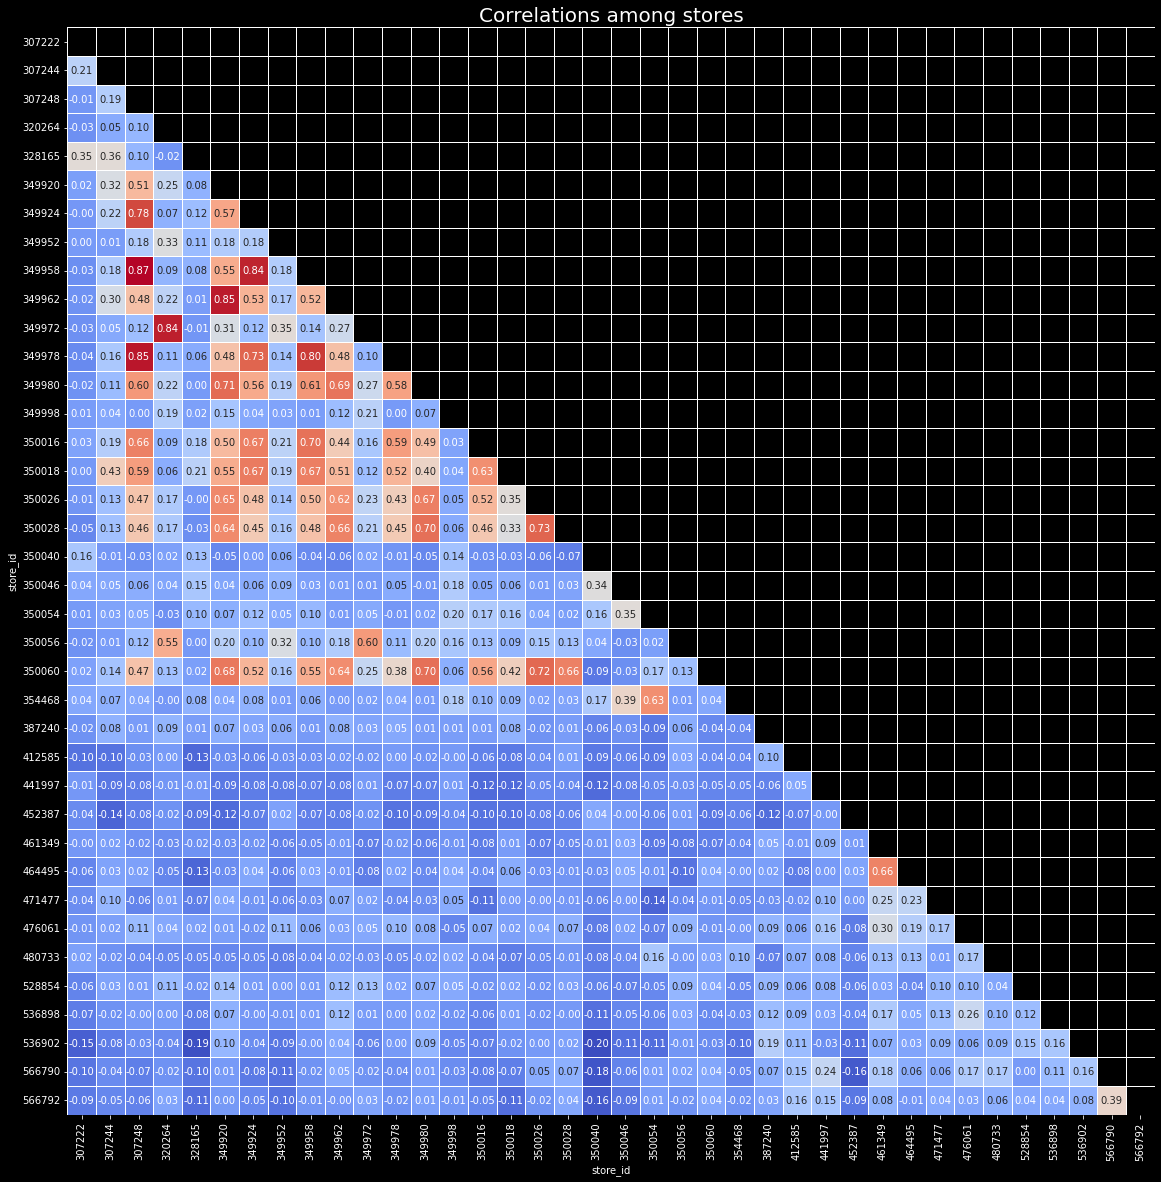

In [22]:
df_store_daily_sum = df_store.set_index('date').groupby('store_id', ).resample('D').sum()['sales'].reset_index(level='store_id')
df_store_daily_sum["ind"] = 1
df_store_daily_sum["ind"] = df_store_daily_sum.groupby("store_id").ind.cumsum().values
df_store_daily_sum_corr = pd.pivot(df_store_daily_sum, index = "ind", columns = "store_id", values = "sales").corr()

mask = np.triu(df_store_daily_sum_corr.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(df_store_daily_sum_corr,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among stores",fontsize = 20)
plt.show()

In [29]:
df_store_daily_sum_corr

store_id,307222,307244,307248,320264,328165,349920,349924,349952,349958,349962,...,461349,464495,471477,476061,480733,528854,536898,536902,566790,566792
store_id,,,,,,,,,,,,,,,,,,,,,
307222,1.000000,0.212170,-0.008963,-0.025201,0.353115,0.015683,-0.002774,0.003165,-0.027939,-0.019679,...,-0.004072,-0.056064,-0.035726,-0.014661,0.018434,-0.058174,-0.073805,-0.149781,-0.097882,-0.085551
307244,0.212170,1.000000,0.185268,0.053704,0.356009,0.316930,0.216069,0.010597,0.179717,0.300939,...,0.017797,0.029842,0.097389,0.018722,-0.021863,0.027026,-0.023313,-0.077116,-0.039227,-0.052302
307248,-0.008963,0.185268,1.000000,0.097277,0.096644,0.510536,0.779341,0.177664,0.869351,0.482935,...,-0.023787,0.021706,-0.059460,0.107016,-0.044551,0.014097,-0.000122,-0.033787,-0.069724,-0.064891
320264,-0.025201,0.053704,0.097277,1.000000,-0.021920,0.248878,0.072727,0.327366,0.085788,0.222306,...,-0.032003,-0.054436,0.006305,0.044835,-0.048692,0.106983,0.004894,-0.039753,-0.019934,0.031998
328165,0.353115,0.356009,0.096644,-0.021920,1.000000,0.080618,0.116816,0.113994,0.078828,0.009832,...,-0.023290,-0.132713,-0.072294,0.021103,-0.053065,-0.016142,-0.079626,-0.188987,-0.097977,-0.111284
349920,0.015683,0.316930,0.510536,0.248878,0.080618,1.000000,0.568112,0.180141,0.551684,0.845173,...,-0.031520,-0.033092,0.039475,0.014831,-0.049382,0.135607,0.074112,0.096515,0.005302,0.000048
349924,-0.002774,0.216069,0.779341,0.072727,0.116816,0.568112,1.000000,0.184714,0.836423,0.530483,...,-0.018668,0.036529,-0.010895,-0.017639,-0.052574,0.009872,-0.003492,-0.035120,-0.083006,-0.047109
349952,0.003165,0.010597,0.177664,0.327366,0.113994,0.180141,0.184714,1.000000,0.183397,0.168960,...,-0.063697,-0.063186,-0.055762,0.107521,-0.077033,0.004225,-0.013475,-0.090935,-0.109752,-0.098899
349958,-0.027939,0.179717,0.869351,0.085788,0.078828,0.551684,0.836423,0.183397,1.000000,0.516973,...,-0.048891,0.032113,-0.033956,0.055169,-0.042960,0.005610,0.008681,-0.002747,-0.017487,-0.013171


---
# Descriptive statistics

In [29]:
df_lev = pd.read_pickle('data/df_lev.pkl').pivot('date','store_level','sales')/1e6
df_lev['A']


date
2017-08-07      1.527650
2017-08-08      0.000000
2017-08-09     34.942320
2017-08-10     20.151840
2017-08-11     24.305380
                 ...    
2021-01-27    348.163092
2021-01-28    365.668841
2021-01-29    455.651168
2021-01-30    668.920990
2021-01-31    968.229512
Name: A, Length: 1274, dtype: float64

In [37]:
# violin plots: company, groups, stores

fig = go.Figure()
fig.add_trace(go.Violin(y=ts_company, name='Company'))
fig.add_trace(go.Violin(y=df_lev['A'], name='Level A'))
fig.add_trace(go.Violin(y=df_lev['B'], name='Level B'))
fig.add_trace(go.Violin(y=df_lev['C'], name='Level C'))

fig.update_layout(yaxis_zeroline=False, height=600, title='Data distribution')
fig.show()

In [62]:
df_store_wide = df_store.loc[:,:'sales'].pivot('date','store_id','sales')/1e6
df_store_wide


store_id,307222,307244,307248,320264,328165,349920,349924,349952,349958,349962,...,461349,464495,471477,476061,480733,528854,536898,536902,566790,566792
date,,,,,,,,,,,,,,,,,,,,,
2017-08-07,1.527650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-08,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-09,26.627420,NaN,NaN,NaN,8.314900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-10,10.755720,2.358650,NaN,NaN,7.037470,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-11,10.216950,0.389000,NaN,NaN,13.699430,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-27,31.418629,10.709426,18.767801,14.902600,56.495801,46.394401,19.679010,17.582000,29.217695,14.1437,...,6.9210,3.539000,12.158002,5.9524,18.9484,29.114201,11.240401,10.6010,26.766327,1.1254
2021-01-28,27.555219,18.901200,21.299800,15.535000,34.744840,33.087529,19.292955,21.157200,31.648258,13.3234,...,4.1772,9.193451,9.812000,7.2276,35.7360,57.254400,8.649200,11.3546,34.114200,1.6668
2021-01-29,35.746445,17.948036,21.749000,13.488100,64.115900,36.954200,28.693600,25.557095,34.560800,18.5998,...,9.0310,2.045000,22.367600,0.3890,40.0356,47.493600,13.645000,12.2770,44.485787,3.3424
